# LIBRARIES IMPORT

**1. Import Necessary Libraries**

In [ ]:
!pip install faiss-cpu
!pip install Groq
!pip install datasets
!pip install adjustText

In [ ]:
import os
import random
import requests
import time

import pandas as pd
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from sentence_transformers import CrossEncoder

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
import faiss
import ast

from datasets import load_dataset

# Import Groq library
try:
    from groq import Groq
    print("Groq library loaded successfully.")
except ImportError:
    print("Groq library not installed. Install using `!pip install groq`.")
    raise

Groq library loaded successfully.


# DATASET

**2. Load QA Dataset**

We load the PopQA Dataset. PopQA is a large-scale open-domain question answering dataset, consisting of 14k entity-centric QA pairs. Each question is created by converting a knowledge tuple retrieved from Wikidata using a template. The dataset contains samples in English only.

In [ ]:
ds = load_dataset("akariasai/PopQA")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.69k [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


test.tsv:   0%|          | 0.00/5.21M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/14267 [00:00<?, ? examples/s]

In [ ]:
# Convert the 'test' dataset to a Pandas DataFrame
df = ds["test"].to_pandas()

# Check the DataFrame
df.head()

,id,subj,prop,obj,subj_id,prop_id,obj_id,s_aliases,o_aliases,s_uri,o_uri,s_wiki_title,o_wiki_title,s_pop,o_pop,question,possible_answers
0,4222362,George Rankin,occupation,politician,1850297,22,2834605,"[""George James Rankin""]","[""political leader"",""political figure"",""polit....",http://www.wikidata.org/entity/Q5543720,http://www.wikidata.org/entity/Q82955,George Rankin,Politician,142,25692,What is George Rankin's occupation?,"[""politician"", ""political leader"", ""political ..."
1,4725190,John Mayne,occupation,journalist,2079053,22,663400,[],"[""journo"",""journalists""]",http://www.wikidata.org/entity/Q6247345,http://www.wikidata.org/entity/Q1930187,John Mayne,Journalist,236,24952,What is John Mayne's occupation?,"[""journalist"", ""journo"", ""journalists""]"
2,4382392,Henry Feilden,occupation,politician,1925450,22,2834605,"[""Henry Master Feilden""]","[""political leader"",""political figure"",""polit....",http://www.wikidata.org/entity/Q5725578,http://www.wikidata.org/entity/Q82955,Henry Feilden (Conservative politician),Politician,58,25692,What is Henry Feilden's occupation?,"[""politician"", ""political leader"", ""political ..."
3,4822110,Kathy Saltzman,occupation,politician,2122743,22,2834605,[],"[""political leader"",""political figure"",""polit....",http://www.wikidata.org/entity/Q6377295,http://www.wikidata.org/entity/Q82955,Kathy Saltzman,Politician,127,25692,What is Kathy Saltzman's occupation?,"[""politician"", ""political leader"", ""political ..."
4,4011112,Eleanor Davis,occupation,cartoonist,1752619,22,68412,"[""Eleanor McCutcheon Davis""]","[""graphic artist"",""animator"",""illustrator""]",http://www.wikidata.org/entity/Q5354261,http://www.wikidata.org/entity/Q1114448,Eleanor Davis,Cartoonist,317,9649,What is Eleanor Davis's occupation?,"[""cartoonist"", ""graphic artist"", ""animator"", ""..."


The data has a graph structure, where columns 'subj' and 'obj' are connected with their relation - 'prop'.

We extract a random subset. This ensures the subset is diverse and representative while ensuring reproducibility with a fixed random seed (seed=42).

In [ ]:
df2 = df.sample(500, random_state=42)

# Taking columns with questions and possible answers for further analysis
questions = df2["question"]
answers = df2["possible_answers"]

Let's take a quick look at the distribution of link types (property values).

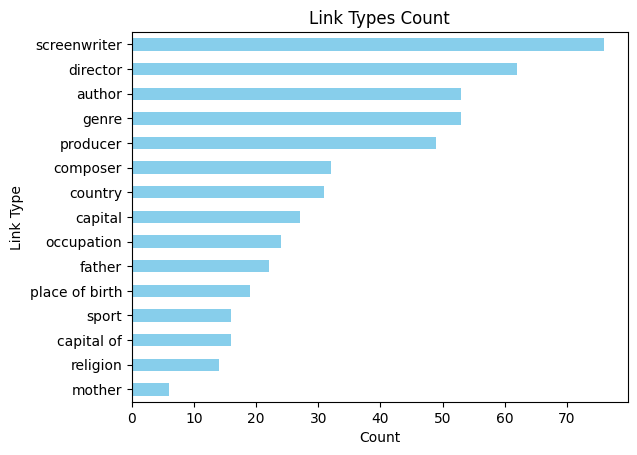

In [ ]:
ax = df2['prop'].value_counts(ascending=True).plot(kind='barh', color='skyblue')

plt.title('Link Types Count')
plt.xlabel('Count')
plt.ylabel('Link Type')
plt.show()

# BASELINE ANSWER GENERATION

**3. Set Up Groq API Client**

In [ ]:
# Set up Groq API key
api_key = os.environ.get("GROQ_API_KEY")
if not api_key:
    api_key = input("Enter your Groq API key: ")
    os.environ["GROQ_API_KEY"] = api_key

# Initialize Groq client
client = Groq()
model_name = "llama3-70b-8192"


**4. Test Groq Chat Functionality**

We use Groq's chat API to generate a response for a sample question: What's the capital of Spain?

In [ ]:
def llama_chat_completion(question, model=model_name, temperature=0, max_tokens=100):
    """
    Send a chat request to the LLaMA model and return the response.
    """
    messages = [{"role": "user", "content": question}]
    try:
        # Ensure the client object is initialized and used correctly
        chat_completion = client.chat.completions.create(
            messages=messages,
            model=model,
            temperature=temperature,
            max_tokens=max_tokens,
        )
        response = chat_completion.choices[0].message.content.strip()
        return response
    except Exception as e:
        print(f"LLaMA chat completion error: {e}")
        return None

# Test the function
test_question = "What is the capital of Spain?"
response = llama_chat_completion(test_question)
print(f"Question: {test_question}")
if response:
    print(f"Response from LLaMA: {response}")
else:
    print("Failed to get a response from LLaMA.")

Question: What is the capital of Spain?
Response from LLaMA: The capital of Spain is Madrid.


**5. Add examples to the prompt**

We included clear instructions and examples to the prompt.

In [ ]:
# Generate responses with examples
def generate_continuation(question):
    examples = """
                Examples:
                Q: What is Leo Messi's occupation?
                A: football player
                Q: What is Hillary Clinton's occupation?
                A: politician
                Q: What is the capital of Russia?
                A: Moscow
                Q: Who is the mother of Alexander the Great?
                A: Olympias

                If you don't know the answer to the question, respond: No idea. Now answer to the following question concisely:
                """
    prompt = examples + f"\nQ: {question}\nA:"
    try:
        chat_completion = client.chat.completions.create(
            messages=[{"role": "user", "content": prompt}],
            model=model_name,
            temperature=0.3,
            max_tokens=100,
            seed=42
        )
        return chat_completion.choices[0].message.content.strip()
    except Exception as e:
        print(f"Error generating response for question '{question}': {e}")
        return None

**6. Baseline Evaluation**

We evaluate Llama's performance on the QA dataset by generating answers and calculating accuracy.

In [ ]:
# List to store answers and ground truth pairs for later evaluation
evaluations = []

# Starting evaluation
print("\nStarting evaluation...")
generated_answers = []
i = 1
for question, answer_list in zip(questions, answers):
    generated = generate_continuation(question)  # Generate answer
    generated_answers.append(generated)  # Store the generated answer

    # Store the question, generated answer, and ground truth in the evaluations list
    evaluations.append({
        'question': question,
        'generated': generated,
        'ground_truth': answer_list
    })

    # Print question, generated answer, and ground truth for review
    print(i)
    print(f"Q: {question}")
    print(f"Generated: {generated}")
    print(f"Ground Truth: {answer_list}\n")

    i += 1

# Now, `evaluations` contains all the answers and ground truth pairs.



Starting evaluation...
1
Q: Who was the screenwriter for On the Town?
Generated: Betty Comden and Adolph Green.
Ground Truth: ["Betty Comden", "Basya Cohen", "Adolph Green"]

2
Q: What is the religion of Juan Soldevilla y Romero?
Generated: No idea.
Ground Truth: ["Catholic Church", "Roman Catholic Church", "Church", "Roman Apostolic Catholic Church"]

3
Q: What genre is Haddaway?
Generated: Eurodance
Ground Truth: ["Eurodance", "Euro-dance", "Euro dance"]

4
Q: Who was the composer of Chances Are?
Generated: Johnny Mathis did not compose "Chances Are", he recorded it. The song was written by Al Stillman and Robert Allen.
Ground Truth: ["Maurice Jarre", "Maurice-Alexis Jarre"]

5
Q: Who was the producer of The Pioneers?
Generated: No idea.
Ground Truth: ["Franklyn Barrett", "Walter Franklyn Barrett"]

6
Q: Who was the screenwriter for The City?
Generated: No idea.
Ground Truth: ["Clyde Fitch", "William Clyde Fitch"]

7
Q: In what city was Jerrold Katz born?
Generated: No idea.
Ground 

We measure if the generated answer exactly matches any of the correct answers. We convert the generated and ground truth answers to lowercase.

In [ ]:
# Function for exact match accuracy
def exact_match_accuracy(predictions, ground_truth):
    correct = []
    for pred, truth in zip(predictions, ground_truth):
        if pred is not None and pred.lower() in truth.lower():
            correct.append(1)
        else:
          check = False
          for i in ast.literal_eval(truth.lower()):
            if (pred is not None) and (i in pred.lower()):
              correct.append(1)
              check = True
              break
          if check == False:
            correct.append(0)
    return (sum(correct) / len(ground_truth)), correct

# Calculate accuracy
accuracy, accuracy_list = exact_match_accuracy(generated_answers, answers)
print(f"Accuracy with Contextual Examples: {accuracy:.2%}")


Accuracy with Contextual Examples: 32.60%


We calculated how many answers of the model were correct, incorrect and "no idea".

In [ ]:
correct = 0
n_no_idea = 0
false_statement = 0
for pred, truth in zip(generated_answers, answers):
    if pred is not None:
        pred_lower = pred.lower()
        truth_lower = truth.lower()

        # Check if prediction matches truth
        if pred_lower in truth_lower:
            correct += 1
        else:
            # Check for "no idea." special case
            if pred_lower == "no idea.":
                n_no_idea += 1
            else:
                # Handle case where truth is a list
                try:
                    for item in ast.literal_eval(truth_lower):
                        if item in pred_lower:
                            correct += 1
                            break
                    else:
                        false_statement += 1  # Increment if no match found
                except (ValueError, SyntaxError):
                    # If truth is not a list, count as false statement
                    false_statement += 1

correct, n_no_idea, false_statement

(163, 218, 119)

We plot the distribution of model's responses.

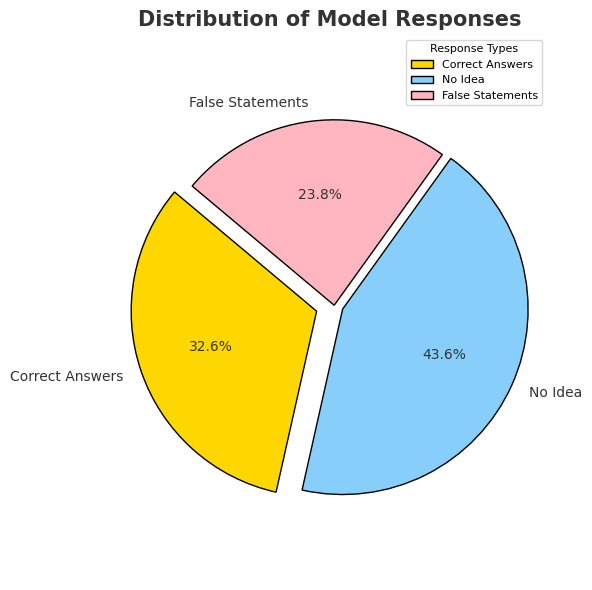

In [ ]:
# Data to plot
labels = ['Correct Answers', 'No Idea', 'False Statements']
sizes = [correct, n_no_idea, false_statement]
colors = ['#FFD700', '#87CEFA', '#FFB6C1']  # Pastel color scheme
explode = (0.1, 0.05, 0)  # Exploding 'Correct Answers' and 'No Idea' for emphasis

# Plot
plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140,
        wedgeprops={'edgecolor': 'black'},  # Black edges for a clean look
        shadow=False, textprops={'fontsize': 10, 'color': '#333333'})  # Text properties
plt.title('Distribution of Model Responses', fontsize=15, fontweight='bold', color='#333333')  # Enhanced title
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.legend(title="Response Types", loc="best", fontsize=8, title_fontsize=8)  # Move legend to the left
plt.grid(False)  # Remove grid for cleaner look
plt.tight_layout()  # Adjust layout to prevent overlap

# Show the plot
plt.show()


However, our current accuracy metric does not cover cases with partial intersection of answers, such as in this example:

```
Q: What genre is Spy?
Generated: Action comedy
Ground Truth: ["comedy film", "comedy movie"]
```
Here is the answer of the model was correct in general, but the word "action" prevents us from matching the results. That is why we need to try a more sophistacted way of model evaluation.

For this purpose can serve Large Language Model (LLM) as a judge evaluation. This means, we are going to ask a model with a different configuration to assess the answers of the previous models. We will ask the model whether the answer is correct or no.

In [ ]:
# Initialize counters for 'Yes' and 'No'
yes_count = 0
no_count = 0

# Loop through the evaluations and ask for relevance
for evaluation in evaluations:
    question = evaluation['question']  # Access the question value
    ground_truth = evaluation['ground_truth']  # Access the ground truth value
    generated_answer = evaluation['generated']  # Access the generated answer value

    # Construct the query for the model
    test_question = f"For example, in the question 'What is the religion of Juan Soldevilla y Romero?', 'Catholic' is relevant to 'Catholic Church' but in the question 'Which programming language is used for Android apps?', 'python' is NOT relevant to 'Java'. 'No idea.' is ALWAYS NOT relevant. Please respond with 'Yes' or 'No': Is this relevant? Question: {question}. Ground Truth: {ground_truth}. Answer: '{generated_answer}'."

    # Get the response from the model
    response = llama_chat_completion(test_question)

    # Output the results
    print(f"Ground Truth: {ground_truth} | Answer: '{generated_answer}'")
    if response:
        print(f"Response from LLaMA: {response}")

        # Count the 'Yes' and 'No' responses
        if response.strip().lower() == "yes":
            yes_count += 1
        elif response.strip().lower() == "no":
            no_count += 1
    else:
        print("Failed to get a response from LLaMA.")

# Print the final count of 'Yes' and 'No' responses
print(f"\nTotal 'Yes' responses: {yes_count}")
print(f"Total 'No' responses: {no_count}")


Ground Truth: ["Betty Comden", "Basya Cohen", "Adolph Green"] | Answer: 'Betty Comden and Adolph Green.'
Response from LLaMA: Yes
Ground Truth: ["Catholic Church", "Roman Catholic Church", "Church", "Roman Apostolic Catholic Church"] | Answer: 'No idea.'
Response from LLaMA: No
Ground Truth: ["Eurodance", "Euro-dance", "Euro dance"] | Answer: 'Eurodance'
Response from LLaMA: Yes
Ground Truth: ["Maurice Jarre", "Maurice-Alexis Jarre"] | Answer: 'Johnny Mathis did not compose "Chances Are", he recorded it. The song was written by Al Stillman and Robert Allen.'
Response from LLaMA: No
Ground Truth: ["Franklyn Barrett", "Walter Franklyn Barrett"] | Answer: 'No idea.'
Response from LLaMA: No
Ground Truth: ["Clyde Fitch", "William Clyde Fitch"] | Answer: 'No idea.'
Response from LLaMA: No
Ground Truth: ["Washington, D.C.", "Washington", "Washington DC", "Washington, DC", "DC", "D.C.", "District of Columbia", "Washington, District of Columbia", "Washington D.C.", "The District"] | Answer: 'No

In [ ]:
print(f"LLM-as-a-judge-score: {yes_count/(yes_count+no_count)*100}%")

LLM-as-a-judge-score: 35.4%


LLM-as-a-judge helped us to find partially correct answers, such as this one
```
Ground Truth: ["comedy film", "comedy movie"] | Answer: 'Action comedy'
Response from LLaMA: Yes
```
However, this method is still prone to hallucinations.
```
Ground Truth: ["Richard Donner", "Richard Donald Schwartzberg"] | Answer: 'Richard D. Zanuck'
Response from LLaMA: Yes
```

Now we create a function that calculates other relevant metrics such as precision, recall, and F-1 score.

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import ast

# Function to calculate precision, recall, and F1 score
def exact_match_f1(predictions, ground_truth):
    y_true = []
    y_pred = []

    for pred, truth in zip(predictions, ground_truth):
        if pred is not None and pred.lower() in truth.lower():
            y_true.append(1)  # True positive
            y_pred.append(1)  # Predicted correctly
        else:
            y_true.append(1)  # Actual positive
            if pred is not None:
                matched = False
                for i in ast.literal_eval(truth.lower()):  # Assuming the ground truth is a list
                    if i in pred.lower():
                        y_pred.append(1)  # Predicted correctly
                        matched = True
                        break
                if not matched:
                    y_pred.append(0)  # False negative
            else:
                y_pred.append(0)  # False negative

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return precision, recall, f1

In [ ]:
# Calculate F1 score
precision, recall, f1 = exact_match_f1(generated_answers, answers)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Precision: 1.00
Recall: 0.33
F1 Score: 0.49


Now, we are analyzing which categories (properties) our model predicts most accurately.

In [ ]:
df2["generated_answers"] = generated_answers

def calculate_accuracy(df, generated_col, possible_col):
    """
    Calculate accuracy by comparing generated answers to possible answers.

    Args:
        df (pd.DataFrame): The dataframe containing the data.
        generated_col (str): The name of the column with generated answers.
        possible_col (str): The name of the column with possible answers.

    Returns:
        pd.Series: A pandas Series containing the accuracy values (1 or 0).
    """
    accuracy = []

    for generated_answers, possible_answers in zip(df[generated_col], df[possible_col]):
        if generated_answers is not None:
            generated_lower = generated_answers.lower()

            # Check if `possible_answers` is a valid list
            try:
                possible_answers_list = ast.literal_eval(possible_answers.lower())
                # Check if any element in the list matches the generated answer
                if any(item in generated_lower for item in possible_answers_list):
                    accuracy.append(1)
                    continue
            except (ValueError, SyntaxError):
                pass

            # If `possible_answers` is not a list, directly check inclusion
            if generated_lower in possible_answers.lower():
                accuracy.append(1)
            else:
                accuracy.append(0)
        else:
            accuracy.append(0)

    return accuracy

# Example usage:
df2["accuracy"] = calculate_accuracy(df2, "generated_answers", "possible_answers")

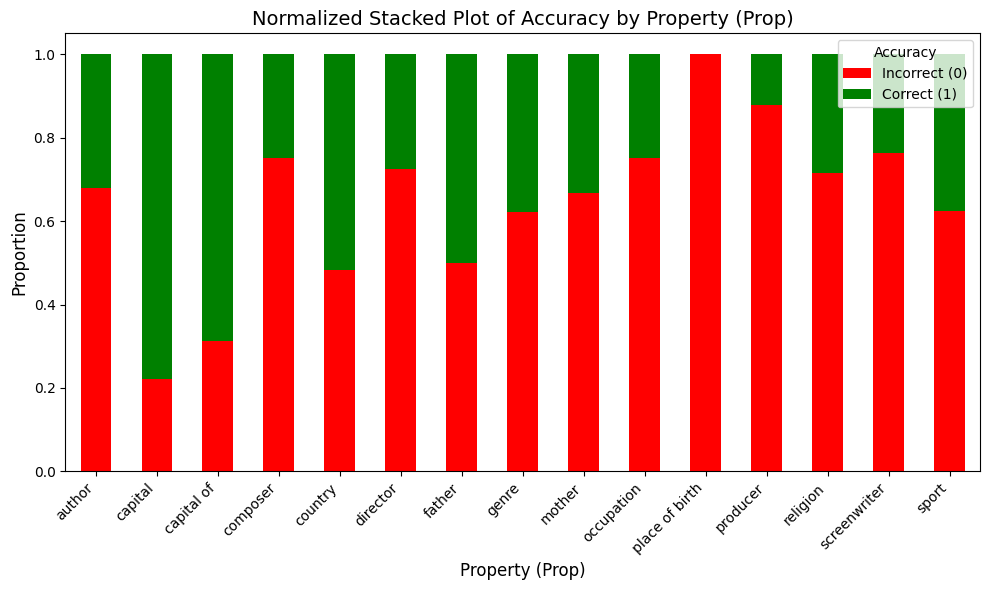

In [ ]:
# Step 1: Create a pivot table to aggregate accuracy counts by 'prop'
pivot_table = df2.pivot_table(
    index='prop',
    columns='accuracy',
    values='id',  # Use 'id' as a placeholder for counting
    aggfunc='count',
    fill_value=0  # Replace NaNs with 0
)

# Step 2: Normalize the pivot table so each row sums to 1
normalized_pivot = pivot_table.div(pivot_table.sum(axis=1), axis=0)

# Step 3: Plot the normalized stacked bar chart with custom colors
colors = ['red', 'green']  # Red for incorrect (0), green for correct (1)
normalized_pivot.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=colors  # Apply custom colors
)

# Step 4: Customize the plot
plt.title('Normalized Stacked Plot of Accuracy by Property (Prop)', fontsize=14)
plt.xlabel('Property (Prop)', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(title='Accuracy', labels=['Incorrect (0)', 'Correct (1)'], fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()



The easiest to guess category seems to be capital, and the hardest is place of birth.

# RAG with Cosine Similarity

**Step 6: Build Context Retrieval System**

We create a retrieval system using SentenceTransformer to retrieve relevant passages from a predefined corpus.

In [ ]:
# Loading embeddings model for creation for both context and query
EMBEDDING_MODEL = "all-MiniLM-L6-v2"  # SentenceTransformer model name

# Load the SentenceTransformer model
embedding_model = SentenceTransformer(EMBEDDING_MODEL)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Step 1: Create the index (database)
def create_index(df, columns_to_index):
    """
    Creates an embedding index from the specified columns in the DataFrame.
    """
    print("Creating index...")
    df['index_content'] = df[columns_to_index].apply(lambda row: " ".join(row.dropna().astype(str)), axis=1)
    df['embedding'] = df['index_content'].apply(
        lambda x: embedding_model.encode(x, convert_to_tensor=False)
    )  # Convert to list instead of tensor for compatibility
    return df

In [ ]:
context_columns = ["subj", "prop", "possible_answers"]  # Columns to index
index = create_index(df2, context_columns)

Creating index...


**Step 7: RAG Evaluation (Llama + Retrieval)**

Use the retrieved context to augment the question and generate a better answer with Llama.

In [ ]:
# Step 2: Retrieve relevant context
def retrieve_context(query, df, top_k=1):
    """
    Retrieves the most relevant rows from the index based on query similarity.
    """
    query_embedding = embedding_model.encode(query, convert_to_tensor=False)
    similarities = df['embedding'].apply(
        lambda x: cosine_similarity([query_embedding], [x]).flatten()[0]
    )
    top_indices = similarities.nlargest(top_k).index

    return df.loc[top_indices]

  # Generate responses with examples
def generate_continuation_context(question, context):
    examples = """
                Examples:
                Q: What is Leo Messi's occupation?
                A: football player
                Q: What is Hillary Clinton's occupation?
                A: politician
                Q: What is the capital of Russia?
                A: Moscow
                Q: Who is the mother of Alexander the Great?
                A: Olympias

                If you don't know the answer to the question, respond: No idea. Now answer to the following question concisely:
                """
    prompt = examples + f"Context:\n{context}\nQ: {question}\nA:"
    try:
        chat_completion = client.chat.completions.create(
            messages=[{"role": "user", "content": prompt}],
            model=model_name,
            temperature=0.3,
            max_tokens=100,
            seed=42
        )
        return chat_completion.choices[0].message.content.strip()
    except Exception as e:
        print(f"Error generating response for question '{question}': {e}")
        return None

In [ ]:
# Initialize a list to store evaluations
evaluations = []

# 3. Evaluate model
print("\nStarting evaluation...")
generated_answers = []
i = 1

for question, answer_list in zip(questions, answers):
    # Retrieve relevant context
    relevant_context = retrieve_context(question, index, top_k=1)
    context_text = "\n".join(relevant_context['index_content'].tolist())

    # Generate continuation based on context
    generated = generate_continuation_context(question, context_text)
    generated_answers.append(generated)  # Store the generated answer

    # Store the evaluation in the list
    evaluation = {
        'question': question,
        'generated': generated,
        'ground_truth': answer_list
    }
    evaluations.append(evaluation)

    # Output the results for this evaluation
    print(i)
    print(f"Q: {question}")
    print(f"Context: {context_text}")
    print(f"Generated: {generated}")
    print(f"Ground Truth: {answer_list}\n")

    i += 1

# After the loop, you will have the evaluations stored in the `evaluations` list
print("\nEvaluations completed.")



Starting evaluation...
1
Q: Who was the screenwriter for On the Town?
Context: On the Town screenwriter ["Betty Comden", "Basya Cohen", "Adolph Green"]
Generated: Betty Comden and Adolph Green
Ground Truth: ["Betty Comden", "Basya Cohen", "Adolph Green"]

2
Q: What is the religion of Juan Soldevilla y Romero?
Context: Juan Soldevilla y Romero religion ["Catholic Church", "Roman Catholic Church", "Church", "Roman Apostolic Catholic Church"]
Generated: Catholic
Ground Truth: ["Catholic Church", "Roman Catholic Church", "Church", "Roman Apostolic Catholic Church"]

3
Q: What genre is Haddaway?
Context: Haddaway genre ["Eurodance", "Euro-dance", "Euro dance"]
Generated: Eurodance
Ground Truth: ["Eurodance", "Euro-dance", "Euro dance"]

4
Q: Who was the composer of Chances Are?
Context: Chances Are composer ["Maurice Jarre", "Maurice-Alexis Jarre"]
Generated: Maurice Jarre
Ground Truth: ["Maurice Jarre", "Maurice-Alexis Jarre"]

5
Q: Who was the producer of The Pioneers?
Context: The Pione

In [ ]:
# Function for exact match accuracy
def exact_match_accuracy(predictions, ground_truth):
    correct = []
    for pred, truth in zip(predictions, ground_truth):
        if pred is not None and pred.lower() in truth.lower():
            correct.append(1)
        else:
          check = False
          for i in ast.literal_eval(truth.lower()):
            if (pred is not None) and (i in pred.lower()):
              correct.append(1)
              check = True
              break
          if check == False:
            correct.append(0)
    return (sum(correct) / len(ground_truth)), correct

# Calculate accuracy
accuracy, accuracy_list = exact_match_accuracy(generated_answers, answers)
print(f"Accuracy with Contextual Examples: {accuracy:.2%}")

Accuracy with Contextual Examples: 89.60%


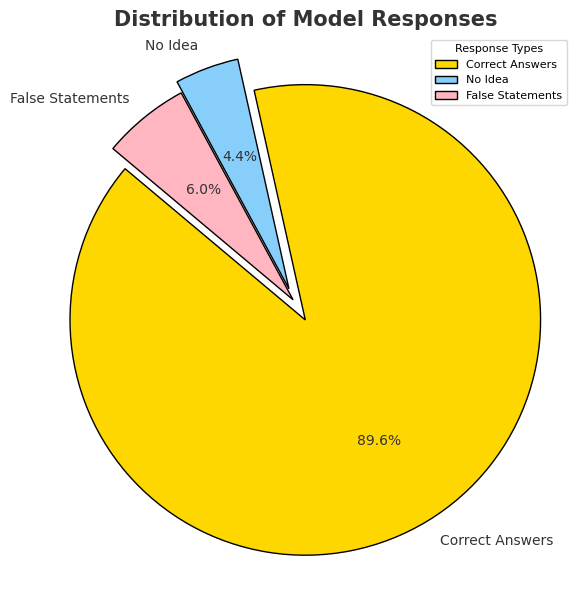

In [ ]:
correct = 0
n_no_idea = 0
false_statement = 0
for pred, truth in zip(generated_answers, answers):
    if pred is not None:
        pred_lower = pred.lower()
        truth_lower = truth.lower()

        # Check if prediction matches truth
        if pred_lower in truth_lower:
            correct += 1
        else:
            # Check for "no idea." special case
            if pred_lower == "no idea.":
                n_no_idea += 1
            else:
                # Handle case where truth is a list
                try:
                    for item in ast.literal_eval(truth_lower):
                        if item in pred_lower:
                            correct += 1
                            break
                    else:
                        false_statement += 1  # Increment if no match found
                except (ValueError, SyntaxError):
                    # If truth is not a list, count as false statement
                    false_statement += 1

# Data to plot
labels = ['Correct Answers', 'No Idea', 'False Statements']
sizes = [correct, n_no_idea, false_statement]
colors = ['#FFD700', '#87CEFA', '#FFB6C1']  # Pastel color scheme
explode = (0.1, 0.05, 0)  # Exploding 'Correct Answers' and 'No Idea' for emphasis

# Plot
plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140,
        wedgeprops={'edgecolor': 'black'},  # Black edges for a clean look
        shadow=False, textprops={'fontsize': 10, 'color': '#333333'})  # Text properties
plt.title('Distribution of Model Responses', fontsize=15, fontweight='bold', color='#333333')  # Enhanced title
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.legend(title="Response Types", loc="best", fontsize=8, title_fontsize=8)  # Move legend to the left
plt.grid(False)  # Remove grid for cleaner look
plt.tight_layout()  # Adjust layout to prevent overlap

# Show the plot
plt.show()

Accuracy has increased dramatically (almost 3 times).

In [ ]:
# Initialize counters for 'Yes' and 'No'
yes_count = 0
no_count = 0

# Loop through the evaluations and ask for relevance
for evaluation in evaluations:
    question = evaluation['question']  # Access the question value
    ground_truth = evaluation['ground_truth']  # Access the ground truth value
    generated_answer = evaluation['generated']  # Access the generated answer value

    # Construct the query for the model
    test_question = f"For example, in the question 'What is the religion of Juan Soldevilla y Romero?', 'Catholic' is relevant to 'Catholic Church' but in the question 'Which programming language is used for Android apps?', 'python' is NOT relevant to 'Java'. 'No idea.' is ALWAYS NOT relevant. Please respond with 'Yes' or 'No': Is this relevant? Question: {question}. Ground Truth: {ground_truth}. Answer: '{generated_answer}'."

    # Get the response from the model
    response = llama_chat_completion(test_question)

    # Output the results
    print(f"Ground Truth: {ground_truth} | Answer: '{generated_answer}'")
    if response:
        print(f"Response from LLaMA: {response}")

        # Count the 'Yes' and 'No' responses
        if response.strip().lower() == "yes":
            yes_count += 1
        elif response.strip().lower() == "no":
            no_count += 1
    else:
        print("Failed to get a response from LLaMA.")

# Print the final count of 'Yes' and 'No' responses
print(f"\nTotal 'Yes' responses: {yes_count}")
print(f"Total 'No' responses: {no_count}")

In [ ]:
print(f"LLM-as-a-judge-score: {yes_count/(yes_count+no_count)*100:.2f}%")

LLM-as-a-judge-score: 89.40%


In [ ]:
df2["generated_answers"] = generated_answers
df2["accuracy"] = calculate_accuracy(df2, "generated_answers", "possible_answers")

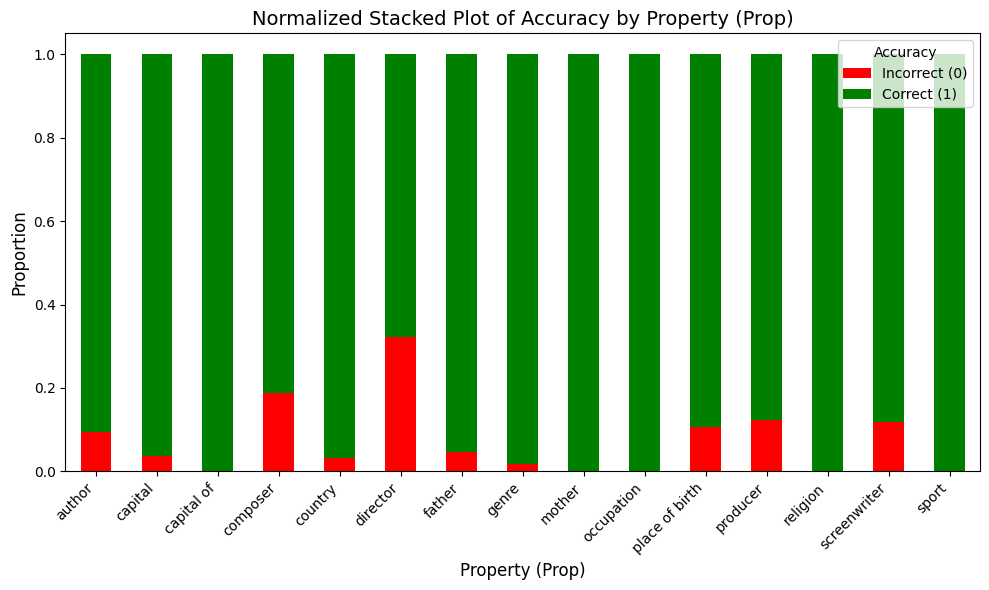

In [ ]:
# Step 1: Create a pivot table to aggregate accuracy counts by 'prop'
pivot_table = df2.pivot_table(
    index='prop',
    columns='accuracy',
    values='id',  # Use 'id' as a placeholder for counting
    aggfunc='count',
    fill_value=0  # Replace NaNs with 0
)

# Step 2: Normalize the pivot table so each row sums to 1
normalized_pivot = pivot_table.div(pivot_table.sum(axis=1), axis=0)

# Step 3: Plot the normalized stacked bar chart with custom colors
colors = ['red', 'green']  # Red for incorrect (0), green for correct (1)
normalized_pivot.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=colors  # Apply custom colors
)

# Step 4: Customize the plot
plt.title('Normalized Stacked Plot of Accuracy by Property (Prop)', fontsize=14)
plt.xlabel('Property (Prop)', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(title='Accuracy', labels=['Incorrect (0)', 'Correct (1)'], fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

Almost a half of categories now show 100% accuracy. Let's look at the wrong answers and their reasons.

###Wrong answers

In [ ]:
df2[df2['accuracy']==0]

,id,subj,prop,obj,subj_id,prop_id,obj_id,s_aliases,o_aliases,s_uri,...,s_wiki_title,o_wiki_title,s_pop,o_pop,question,possible_answers,generated_answers,accuracy,index_content,embedding
9240,1332312,The City,screenwriter,Clyde Fitch,592187,533,983985,"[""City""]","[""William Clyde Fitch""]",http://www.wikidata.org/entity/Q18148906,...,The City (1916 film),Clyde Fitch,71,570,Who was the screenwriter for The City?,"[""Clyde Fitch"", ""William Clyde Fitch""]",David Greenwalt,0,"The City screenwriter [""Clyde Fitch"", ""William...","[-0.0018575367, -0.07346333, -0.021471, 0.0064..."
12399,1387463,Revolution,author,Russell Brand,620814,484,980840,[],"[""Russell Edward Brand""]",http://www.wikidata.org/entity/Q18394192,...,Revolution (book),Russell Brand,796,193217,Who is the author of Revolution?,"[""Russell Brand"", ""Russell Edward Brand""]",Jennifer Donnelly,0,"Revolution author [""Russell Brand"", ""Russell E...","[-0.059040222, 0.06881728, 0.026845058, -0.039..."
1039,4657020,Jeanne de Casalis,place of birth,Basutoland,2052031,218,798931,"[""Jeanne Casalis""]",[],http://www.wikidata.org/entity/Q6172236,...,Jeanne de Casalis,Basutoland,2730,5380,In what city was Jeanne de Casalis born?,"[""Basutoland""]",No idea.,0,"Jeanne de Casalis place of birth [""Basutoland""]","[-0.002127301, 0.07658476, -0.07401654, 0.0103..."
13991,3741171,Bury,capital,Bury,1625801,422,1445866,"[""Metropolitan Borough of Bury"",""Bury (unparis...","[""Bury, Greater Manchester""]",http://www.wikidata.org/entity/Q512036,...,Metropolitan Borough of Bury,"Bury, Greater Manchester",1821,9860,What is the capital of Bury?,"[""Bury"", ""Bury, Greater Manchester""]",No idea.,0,"Bury capital [""Bury"", ""Bury, Greater Manchester""]","[0.09605074, -0.018567497, 0.047203884, -0.011..."
5697,414341,Bhoopathi Ranga,director,Geethapriya,167588,526,1841434,[],"[""Lakshman Rao Mohite""]",http://www.wikidata.org/entity/Q13160435,...,Bhoopathi Ranga,Geethapriya,164,502,Who was the director of Bhoopathi Ranga?,"[""Geethapriya"", ""Lakshman Rao Mohite""]",Puttanna Kanagal,0,"Bhoopathi Ranga director [""Geethapriya"", ""Laks...","[-0.078999646, 0.028481657, -0.028886395, -0.0..."
6088,3577982,Broke,director,Steve Carell,1547329,526,752737,[],"[""Steven John \""Steve\"" Carell"",""Steven John C...",http://www.wikidata.org/entity/Q4973268,...,Broke (The Office),Steve Carell,3186,223875,Who was the director of Broke?,"[""Steve Carell"", ""Steven John \""Steve\"" Carell...",No idea.,0,"Broke director [""Steve Carell"", ""Steven John \...","[-0.07432046, -0.044580452, 0.04886818, 0.0001..."
4400,6293255,Tyr,producer,Black Sabbath,2839704,164,1436859,[],[],http://www.wikidata.org/entity/Q838304,...,Tyr (album),Black Sabbath,7427,156286,Who was the producer of Tyr?,"[""Black Sabbath""]",Rupert Hine,0,"Tyr producer [""Black Sabbath""]","[-0.068537846, 0.040482044, -0.06124648, -0.04..."
10796,4396097,Hero,composer,Mani Sharma,1931109,639,2240414,[],"[""Yanamandra Venkata Subrahmanya Sharma""]",http://www.wikidata.org/entity/Q5742571,...,Hero (2008 film),Mani Sharma,1839,16944,Who was the composer of Hero?,"[""Mani Sharma"", ""Yanamandra Venkata Subrahmany...",Tan Dun,0,"Hero composer [""Mani Sharma"", ""Yanamandra Venk...","[-0.05021614, 0.013376055, -0.056551814, -0.00..."
6720,2107251,Restless,director,Joss Whedon,922577,526,983942,[],"[""Joseph Hill Whedon""]",http://www.wikidata.org/entity/Q2740175,...,Restless (Buffy the Vampire Slayer),Joss Whedon,1495,122100,Who was the director of Restless?,"[""Joss Whedon"", ""Joseph Hill Whedon""]",No idea.,0,"Restless director [""Joss Whedon"", ""Joseph Hill...","[-0.09383267, 0.028015643, -0.04242824, 0.0332..."
6592,3218767,Pilot,director,Alex Graves,1379637,526,1405385,"[""Fringe pilot""]","[""Alexander Graves"",""Alexander John Graves""]",http://www.wikidata.org/entity/Q467431,...,Pilot (Fringe),Alex Graves,1261,3793,Who was the director of Pilot?,"[""Alex Graves"", ""Alexander Graves"", ""Alexander...",Bobby Roth,0,"Pilot director ["

###Wrong context

There are 52 wrong answers according to the accuracy measure. In theory, these may be wrong due to internal LLMs hallucinations. Another reason may be that a wrong context was given within the prompt. We are going to check whether the contexts that were given to the model align with the gold labels.

In [ ]:
i=1
for row in df2.itertuples():
  relevant_context = retrieve_context(row.question, index, top_k=1)
  context_text = "\n".join(relevant_context['index_content'].tolist())
  if context_text != row.index_content:
    print(i)
    print(row.question)
    print("Chosen context: ", context_text)
    print("True context: ", row.index_content)
    print()
    i+=1

1
Who was the screenwriter for The City?
Chosen context:  City Of screenwriter ["David Greenwalt"]
True context:  The City screenwriter ["Clyde Fitch", "William Clyde Fitch"]

2
Who is the author of Revolution?
Chosen context:  Revolution author ["Jennifer Donnelly"]
True context:  Revolution author ["Russell Brand", "Russell Edward Brand"]

3
Who was the composer of Hero?
Chosen context:  The Miracle composer ["Elmer Bernstein"]
True context:  Hero composer ["Mani Sharma", "Yanamandra Venkata Subrahmanya Sharma"]

4
Who was the director of Pilot?
Chosen context:  Pilot screenwriter ["Paul Scheuring"]
True context:  Pilot director ["Alex Graves", "Alexander Graves", "Alexander John Graves"]

5
Who was the screenwriter for In His Hands?
Chosen context:  The Ones screenwriter ["Jack Burditt"]
True context:  In His Hands screenwriter ["Anne Fontaine", "Anne Fontaine Sibertin-Blanc"]

6
Who was the director of Her?
Chosen context:  First Love director ["Joan Darling"]
True context:  Her di

As we can see, almost half of mistakes could be due to the wrong context chosen. So, probably, cosine similarity does not always find the best option within our index. Perhaps, we still can improve our accuracy. To do so, we should try another method for context selection.

# RAG with Reranker Evaluation

**Step 8: RAG with Reranker Evaluation**


We tried using a reranker, which evaluates the query-context relationship by considering the full semantic meaning of the pair, rather than relying solely on vector similarity.

In [ ]:
# Load the reranker model
reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

def retrieve_context(query, df, top_k=5):
    """
    Retrieves the top-k most relevant rows using initial embedding similarity.
    """
    query_embedding = embedding_model.encode(query, convert_to_tensor=False)
    similarities = df['embedding'].apply(
        lambda x: cosine_similarity([query_embedding], [x]).flatten()[0]
    )
    top_indices = similarities.nlargest(top_k).index
    return df.loc[top_indices]

def rerank_context(query, candidates_df):
    """
    Rerank the retrieved candidates using a reranker model.
    """
    # Pair the query with each candidate for reranking
    pairs = [(query, row['index_content']) for _, row in candidates_df.iterrows()]

    # Use the CrossEncoder model to score each query-context pair
    scores = reranker.predict(pairs)

    # Add scores to the DataFrame and sort by score in descending order
    candidates_df['rerank_score'] = scores
    reranked_df = candidates_df.sort_values(by='rerank_score', ascending=False)
    return reranked_df.iloc[0]  # Return the best match

def generate_continuation_context(question, context):
    examples = """
                Examples:
                Q: What is Leo Messi's occupation?
                A: football player
                Q: What is Hillary Clinton's occupation?
                A: politician
                Q: What is the capital of Russia?
                A: Moscow
                Q: Who is the mother of Alexander the Great?
                A: Olympias

                If you don't know the answer to the question, respond: No idea. Now answer to the following question concisely:
                """
    prompt = examples + f"Context:\n{context}\nQ: {question}\nA:"
    try:
        chat_completion = client.chat.completions.create(
            messages=[{"role": "user", "content": prompt}],
            model=model_name,
            temperature=0.3,
            max_tokens=100,
            seed=42
        )
        return chat_completion.choices[0].message.content.strip()
    except Exception as e:
        print(f"Error generating response for question '{question}': {e}")
        return None



In [ ]:
# Initialize a list to store evaluations
evaluations = []

print("\nStarting evaluation...")
generated_answers = []  # List to store generated answers
i = 1

for question, answer_list in zip(questions, answers):
    # Step 1: Retrieve the top-k most relevant contexts
    top_k_candidates = retrieve_context(question, index, top_k=5)

    # Step 2: Rerank the top-k contexts
    best_context = rerank_context(question, top_k_candidates)
    context_text = best_context['index_content']  # Extract the best context after reranking

    # Step 3: Generate a response using the selected context
    generated = generate_continuation_context(question, context_text)
    generated_answers.append(generated)

    # Step 4: Store the evaluation in the list
    evaluation = {
        'question': question,
        'generated': generated,
        'ground_truth': answer_list
    }
    evaluations.append(evaluation)

    # Print the question, generated answer, and ground truth
    print(i)
    print(f"Q: {question}")
    print(f"Generated: {generated}")
    print(f"Ground Truth: {answer_list}\n")
    i += 1

# After the loop, you will have the evaluations stored in the `evaluations` list
print("\nEvaluations completed.")




In [ ]:
# Calculate accuracy
accuracy, accuracy_list = exact_match_accuracy(generated_answers, answers)
print(f"Accuracy with Contextual Examples: {accuracy:.2%}")


Accuracy with Contextual Examples: 91.40%


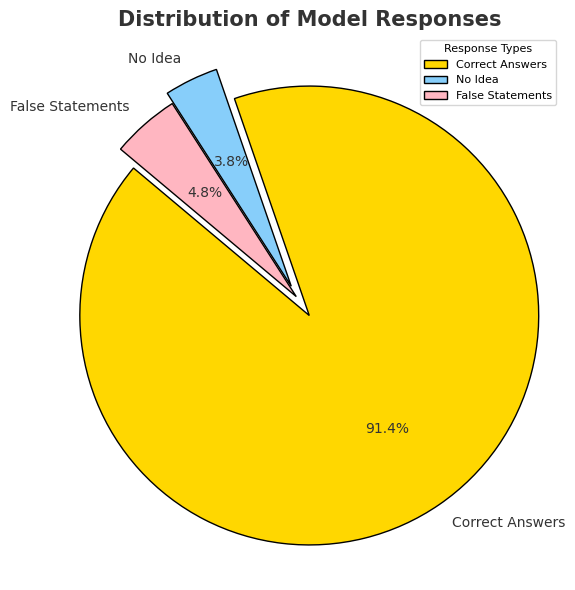

In [ ]:
correct = 0
n_no_idea = 0
false_statement = 0
for pred, truth in zip(generated_answers, answers):
    if pred is not None:
        pred_lower = pred.lower()
        truth_lower = truth.lower()

        # Check if prediction matches truth
        if pred_lower in truth_lower:
            correct += 1
        else:
            # Check for "no idea." special case
            if pred_lower == "no idea.":
                n_no_idea += 1
            else:
                # Handle case where truth is a list
                try:
                    for item in ast.literal_eval(truth_lower):
                        if item in pred_lower:
                            correct += 1
                            break
                    else:
                        false_statement += 1  # Increment if no match found
                except (ValueError, SyntaxError):
                    # If truth is not a list, count as false statement
                    false_statement += 1

# Data to plot
labels = ['Correct Answers', 'No Idea', 'False Statements']
sizes = [correct, n_no_idea, false_statement]
colors = ['#FFD700', '#87CEFA', '#FFB6C1']  # Pastel color scheme
explode = (0.1, 0.05, 0)  # Exploding 'Correct Answers' and 'No Idea' for emphasis

# Plot
plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140,
        wedgeprops={'edgecolor': 'black'},  # Black edges for a clean look
        shadow=False, textprops={'fontsize': 10, 'color': '#333333'})  # Text properties
plt.title('Distribution of Model Responses', fontsize=15, fontweight='bold', color='#333333')  # Enhanced title
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.legend(title="Response Types", loc="best", fontsize=8, title_fontsize=8)  # Move legend to the left
plt.grid(False)  # Remove grid for cleaner look
plt.tight_layout()  # Adjust layout to prevent overlap

# Show the plot
plt.show()

In [ ]:
# Initialize counters for 'Yes' and 'No'
yes_count = 0
no_count = 0

# Loop through the evaluations and ask for relevance
for evaluation in evaluations:
    question = evaluation['question']  # Access the question value
    ground_truth = evaluation['ground_truth']  # Access the ground truth value
    generated_answer = evaluation['generated']  # Access the generated answer value

    # Construct the query for the model
    test_question = f"For example, in the question 'What is the religion of Juan Soldevilla y Romero?', 'Catholic' is relevant to 'Catholic Church' but in the question 'Which programming language is used for Android apps?', 'python' is NOT relevant to 'Java'. 'No idea.' is ALWAYS NOT relevant. Please respond with 'Yes' or 'No': Is this relevant? Question: {question}. Ground Truth: {ground_truth}. Answer: '{generated_answer}'."

    # Get the response from the model
    response = llama_chat_completion(test_question)

    # Output the results
    print(f"Ground Truth: {ground_truth} | Answer: '{generated_answer}'")
    if response:
        print(f"Response from LLaMA: {response}")

        # Count the 'Yes' and 'No' responses
        if response.strip().lower() == "yes":
            yes_count += 1
        elif response.strip().lower() == "no":
            no_count += 1
    else:
        print("Failed to get a response from LLaMA.")

# Print the final count of 'Yes' and 'No' responses
print(f"\nTotal 'Yes' responses: {yes_count}")
print(f"Total 'No' responses: {no_count}")

In [ ]:
print(f"LLM-as-a-judge-score: {yes_count/(yes_count+no_count)*100:.2f}%")

LLM-as-a-judge-score: 91.20%


In [ ]:
# Calculate F1 score
precision, recall, f1 = exact_match_f1(generated_answers, answers)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Precision: 1.00
Recall: 0.91
F1 Score: 0.96


In [ ]:
def calculate_accuracy(df, generated_col, possible_col):
    """
    Calculate accuracy by comparing generated answers to possible answers.

    Args:
        df (pd.DataFrame): The dataframe containing the data.
        generated_col (str): The name of the column with generated answers.
        possible_col (str): The name of the column with possible answers.

    Returns:
        pd.Series: A pandas Series containing the accuracy values (1 or 0).
    """
    accuracy = []

    for generated_answers, possible_answers in zip(df[generated_col], df[possible_col]):
        if generated_answers is not None:
            generated_lower = generated_answers.lower()

            # Check if `possible_answers` is a valid list
            try:
                possible_answers_list = ast.literal_eval(possible_answers.lower())
                # Check if any element in the list matches the generated answer
                if any(item in generated_lower for item in possible_answers_list):
                    accuracy.append(1)
                    continue
            except (ValueError, SyntaxError):
                pass

            # If `possible_answers` is not a list, directly check inclusion
            if generated_lower in possible_answers.lower():
                accuracy.append(1)
            else:
                accuracy.append(0)
        else:
            accuracy.append(0)

    return accuracy

df2["generated_answers"] = generated_answers
df2["accuracy"] = calculate_accuracy(df2, "generated_answers", "possible_answers")

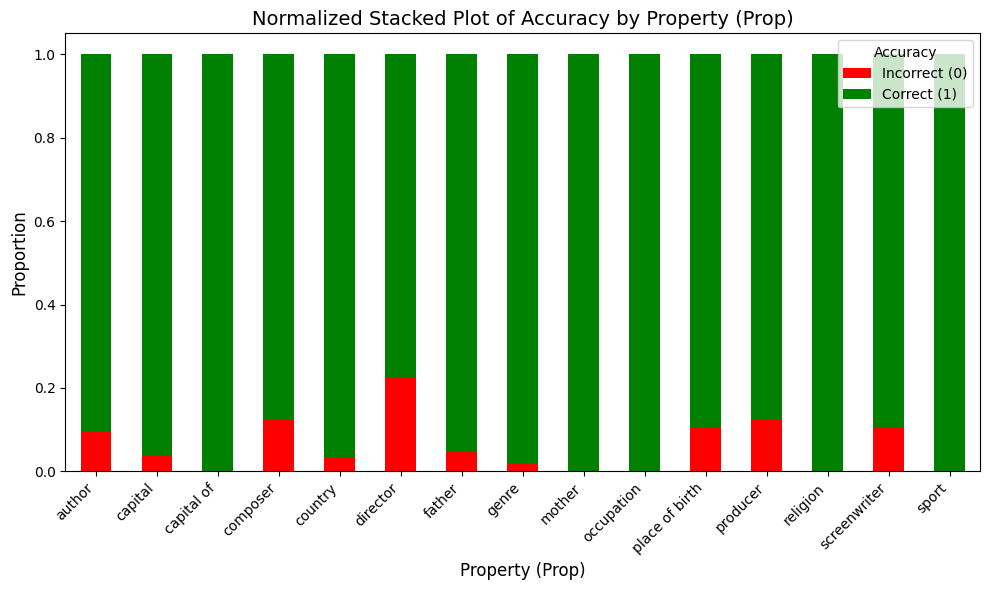

In [ ]:
# Step 1: Create a pivot table to aggregate accuracy counts by 'prop'
pivot_table = df2.pivot_table(
    index='prop',
    columns='accuracy',
    values='id',  # Use 'id' as a placeholder for counting
    aggfunc='count',
    fill_value=0  # Replace NaNs with 0
)

# Step 2: Normalize the pivot table so each row sums to 1
normalized_pivot = pivot_table.div(pivot_table.sum(axis=1), axis=0)

# Step 3: Plot the normalized stacked bar chart with custom colors
colors = ['red', 'green']  # Red for incorrect (0), green for correct (1)
normalized_pivot.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=colors  # Apply custom colors
)

# Step 4: Customize the plot
plt.title('Normalized Stacked Plot of Accuracy by Property (Prop)', fontsize=14)
plt.xlabel('Property (Prop)', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(title='Accuracy', labels=['Incorrect (0)', 'Correct (1)'], fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

###Wrong answers

In [ ]:
df2[df2['accuracy']==0]

,id,subj,prop,obj,subj_id,prop_id,obj_id,s_aliases,o_aliases,s_uri,...,s_wiki_title,o_wiki_title,s_pop,o_pop,question,possible_answers,generated_answers,accuracy,index_content,embedding
9240,1332312,The City,screenwriter,Clyde Fitch,592187,533,983985,"[""City""]","[""William Clyde Fitch""]",http://www.wikidata.org/entity/Q18148906,...,The City (1916 film),Clyde Fitch,71,570,Who was the screenwriter for The City?,"[""Clyde Fitch"", ""William Clyde Fitch""]",David Greenwalt,0,"The City screenwriter [""Clyde Fitch"", ""William...","[-0.0018575367, -0.07346333, -0.021471, 0.0064..."
12399,1387463,Revolution,author,Russell Brand,620814,484,980840,[],"[""Russell Edward Brand""]",http://www.wikidata.org/entity/Q18394192,...,Revolution (book),Russell Brand,796,193217,Who is the author of Revolution?,"[""Russell Brand"", ""Russell Edward Brand""]",Jennifer Donnelly,0,"Revolution author [""Russell Brand"", ""Russell E...","[-0.059040222, 0.06881728, 0.026845058, -0.039..."
1039,4657020,Jeanne de Casalis,place of birth,Basutoland,2052031,218,798931,"[""Jeanne Casalis""]",[],http://www.wikidata.org/entity/Q6172236,...,Jeanne de Casalis,Basutoland,2730,5380,In what city was Jeanne de Casalis born?,"[""Basutoland""]",No idea.,0,"Jeanne de Casalis place of birth [""Basutoland""]","[-0.002127301, 0.07658476, -0.07401654, 0.0103..."
13991,3741171,Bury,capital,Bury,1625801,422,1445866,"[""Metropolitan Borough of Bury"",""Bury (unparis...","[""Bury, Greater Manchester""]",http://www.wikidata.org/entity/Q512036,...,Metropolitan Borough of Bury,"Bury, Greater Manchester",1821,9860,What is the capital of Bury?,"[""Bury"", ""Bury, Greater Manchester""]",No idea.,0,"Bury capital [""Bury"", ""Bury, Greater Manchester""]","[0.09605074, -0.018567497, 0.047203884, -0.011..."
5697,414341,Bhoopathi Ranga,director,Geethapriya,167588,526,1841434,[],"[""Lakshman Rao Mohite""]",http://www.wikidata.org/entity/Q13160435,...,Bhoopathi Ranga,Geethapriya,164,502,Who was the director of Bhoopathi Ranga?,"[""Geethapriya"", ""Lakshman Rao Mohite""]",Puttanna Kanagal,0,"Bhoopathi Ranga director [""Geethapriya"", ""Laks...","[-0.078999646, 0.028481657, -0.028886395, -0.0..."
6088,3577982,Broke,director,Steve Carell,1547329,526,752737,[],"[""Steven John \""Steve\"" Carell"",""Steven John C...",http://www.wikidata.org/entity/Q4973268,...,Broke (The Office),Steve Carell,3186,223875,Who was the director of Broke?,"[""Steve Carell"", ""Steven John \""Steve\"" Carell...",No idea.,0,"Broke director [""Steve Carell"", ""Steven John \...","[-0.07432046, -0.044580452, 0.04886818, 0.0001..."
4400,6293255,Tyr,producer,Black Sabbath,2839704,164,1436859,[],[],http://www.wikidata.org/entity/Q838304,...,Tyr (album),Black Sabbath,7427,156286,Who was the producer of Tyr?,"[""Black Sabbath""]",Rupert Hine,0,"Tyr producer [""Black Sabbath""]","[-0.068537846, 0.040482044, -0.06124648, -0.04..."
6720,2107251,Restless,director,Joss Whedon,922577,526,983942,[],"[""Joseph Hill Whedon""]",http://www.wikidata.org/entity/Q2740175,...,Restless (Buffy the Vampire Slayer),Joss Whedon,1495,122100,Who was the director of Restless?,"[""Joss Whedon"", ""Joseph Hill Whedon""]",No idea.,0,"Restless director [""Joss Whedon"", ""Joseph Hill...","[-0.09383267, 0.028015643, -0.04242824, 0.0332..."
9419,2205688,City Of,screenwriter,David Greenwalt,963478,533,819502,[],[],http://www.wikidata.org/entity/Q2902020,...,City Of,David Greenwalt,1407,2402,Who was the screenwriter for City Of?,"[""David Greenwalt""]",Joss Whedon,0,"City Of screenwriter [""David Greenwalt""]","[0.0027380532, 0.0012006833, -0.02806672, -0.0..."
8729,2309001,In His Hands,screenwriter,Anne Fontaine,1007458,533,967441,"[""Entre ses mains""]","[""Anne Fontaine Sibertin-Blanc""]",http://www.wikidata.org/entity/Q3055215,...,Entre ses mains,Anne Fontaine,298,1451,Who was the screenwriter for In His Hands?,"[""Anne Fontaine"", ""Anne Fontaine Sibertin-Blanc""]",No idea.,0,"In His Hands screenwriter [""Anne Fontaine"", ""A...","[-0.026550232, -0.0

###Wrong context

In [ ]:
i=1
for row in df2.itertuples():
  top_k_candidates = retrieve_context(row.question, index, top_k=5)
  best_context = rerank_context(row.question, top_k_candidates)
  context_text = best_context['index_content']
  if context_text != row.index_content:
    print(i)
    print(row.question)
    print("Chosen context: ", context_text)
    print("True context: ", row.index_content)
    print()
    i+=1

1
Who was the screenwriter for The City?
Chosen context:  City Of screenwriter ["David Greenwalt"]
True context:  The City screenwriter ["Clyde Fitch", "William Clyde Fitch"]

2
Who is the author of Revolution?
Chosen context:  Revolution author ["Jennifer Donnelly"]
True context:  Revolution author ["Russell Brand", "Russell Edward Brand"]

3
Who was the screenwriter for In His Hands?
Chosen context:  The Man screenwriter ["Jim Piddock"]
True context:  In His Hands screenwriter ["Anne Fontaine", "Anne Fontaine Sibertin-Blanc"]

4
Who is the author of The Village?
Chosen context:  This Is It author ["Joseph Connolly"]
True context:  The Village author ["Ivan Bunin", "Ivan Alekseyevich Bunin"]

5
Who is the author of A Legacy?
Chosen context:  Ahead of Time author ["Henry Kuttner", "Smith, Woodrow Wilson"]
True context:  A Legacy author ["Sybille Bedford", "Sybille Von Schoenebeck"]

6
Who was the screenwriter for A New Day?
Chosen context:  The Ones screenwriter ["Jack Burditt"]
True c

Reranking helped us reduce the number of incorrect contexts by more than half and improved accuracy by a few percentage points.

#Conclusion

The results of the project underscore the importance of grounding language models in external knowledge for improved QA performance.
Reranking helps to retrieve the most similar context for further prompting.
